# <center> Lab sheet5 </center>

Student ID: 22670287 <br>
Student Name: Xiaoyan Huang <br>
Date created: 05/05/2020 <br>
Last modified: 18/05/2020 <br>

The aim of this task is to train an MLP and a CNN for the classification task and compare their performance.

## 1. Data Download and Preparation


In [0]:
import numpy as np
np.random.seed(1)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import pickle
from google.colab import drive

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import initializers
import pandas as pd

from sklearn.metrics import confusion_matrix
from keras.models import model_from_json

# import other packages needed for the project below this line

# IMPOTRTANT: set the path where the data files are relative to the Notebook file. 
# You can change the variable pathname below to anything that suits you, For example,
# if your Notebook file is to be run on Google Colab, then you will need to set up
# this variable properly, e.g., 
#       pathname = os.path.join('My Drive', 'CITS5508').
#
# Before submitting your Notebook file to cssubmit, ensure that you change
# this variable back to '.'

pathname = '.'
# drive.mount('/content/gdrive')
# print(os.listdir('.'))
# pathname = '/content/gdrive/My Drive/Colab Notebooks/cifar-10-batches-py'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['.config', 'gdrive', 'sample_data']


In [0]:
# function for loading the data_batch_file
def load_pickle_file(filename, path='.'):
    '''
    This function reads the given pickle file and returns a dictionary object.
    '''
    with open(os.path.join(path,filename), 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict  


def load_training(filename_prefix, N_batches, path='.'):
    '''
    This function reads the 5 data batches and returns the X_train and y_train numpy arrays.
    To save memory space, X_train is set to 'float32' (single precision floating point number).
    If this causes an issue, it can be set to 'float64'. y_train is set to uint8. This is
    the same data type as the MNIST dataset, so it should be fine.
    '''
    batch_no = range(1,N_batches+1)  # the batch numbers start at 1
    # Read in the data_batch_ files
    batches = [load_pickle_file(os.path.join(path,filename_prefix+str(b))) for b in batch_no]

    # variable batches is a list containing 5 elements, each of which is a dictionary object

    # compose our X_train and y_train
    # according to the download site, the training set should have 50,000 instances. We caldulate
    # the length from the dictionary that we read in anyway.
    batch_sizes = [len(batches[i][b'labels']) for i in range(N_batches)]
    train_set_size = np.sum(batch_sizes)
    
    X_train = np.zeros((train_set_size, width, height, Nchannels), dtype='float32')
    y_train = np.zeros(train_set_size).astype('uint8')
    loc = 0
    for i in range(N_batches):
        X_train[loc:(loc+batch_sizes[i]),:,:,:] = np.swapaxes(np.swapaxes(
            np.reshape(batches[i][b'data'], (-1,Nchannels,width,height)), 1, 3), 1, 2) / 255.0
        y_train[loc:(loc+batch_sizes[i])] = batches[i][b'labels']
        loc += batch_sizes[i]
    return X_train, y_train


def load_testing(filename, path='.'):
    '''
    This function reads the test_batch and returns X_test and y_test.
    To save memory space, X_test is set to 'float32' (single precision floating point number).
    If this causes an issue, it can be set to 'float64'. y_test is set to uint8. This is
    the same data type as the MNIST dataset, so it should be fine.
    '''
    # now read test_batch and construct the test set
    test_dict = load_pickle_file(filename, path=path)
    
    X_test = np.swapaxes(np.swapaxes(
        np.reshape(test_dict[b'data'], (-1,Nchannels,width,height)), 1, 3), 1, 2) / 255.0
    X_test = X_test.astype('float32')
    y_test = np.array(test_dict[b'labels'], dtype='uint8')
    return X_test, y_test

In [0]:
print(os.listdir(pathname))

['model_cnn.json', 'model_cnn.h5', 'lab05.ipynb', 'test_batch', 'data_batch_3', 'data_batch_2', 'data_batch_5', 'data_batch_1', 'data_batch_4', 'batches.meta', 'readme.html']


In [0]:
# According to the download site, the training set is split into five batches stored in 5 files,
# each colour image has dimension equal to 32 x 32 x 3, and there are 10 classes.
width, height, Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

N_batches = 5  
train_filename_prefix = 'data_batch_'
test_filename = 'test_batch'

X_train, y_train = load_training(train_filename_prefix, N_batches, path=pathname)
X_test, y_test = load_testing(test_filename, path=pathname)

train_set_size = X_train.shape[0]
test_set_size = X_test.shape[0]
print('Number of train instances:', train_set_size)
print('Number of test instances:', test_set_size)

Number of train instances: 50000
Number of test instances: 10000


In [0]:
# inspect the shape of  X_train, y_train, X_test, and y_test
print('X_train.shape =', X_train.shape, 'data type:', X_train.dtype)
print('y_train.shape =', y_train.shape, 'data type:', y_train.dtype)
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_train.shape = (50000, 32, 32, 3) data type: float32
y_train.shape = (50000,) data type: uint8
X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000,) data type: uint8


In [0]:
# split X_train into a small validation set and training set
X_valid, X_training = X_train[:5000], X_train[5000:]
y_valid, y_training = y_train[:5000], y_train[5000:]

In [0]:
# inspect the shape of training set, valid set and test set individually
print('X_valid.shape =', X_valid.shape, 'data type:', X_valid.dtype)
print('X_training.shape =', X_training.shape, 'data type:', X_training.dtype)
print('y_valid.shape =', y_valid.shape, 'data type:', y_valid.dtype)
print('y_training.shape =', y_training.shape, 'data type:', y_training.dtype)

X_valid.shape = (5000, 32, 32, 3) data type: float32
X_training.shape = (45000, 32, 32, 3) data type: float32
y_valid.shape = (5000,) data type: uint8
y_training.shape = (45000,) data type: uint8


*   Constructing functions for loading datasets.
*   Getting the train and test dataset. The number of train instances is 50,000, and 10,000 instances in test dateset.
*   Spliting the validation set from train dataset. There are 45,000 instances for training and 5000 for validation.




## 2. MLP



### 2.1 Find the optimal parameters
Exploring the different hyperparameters such as **connection weight initialisation**, **learning rate scheduling** and **early stopping**, they are compared by model accuracy and the best model would be picked up and exhibited below.

case1
1. weight initialisation is random_uniform
2. learning rate is 0.01
3. early stopping (monitor="val_loss", patience=10, restore_best_weights=True)
4. the model accuracy is 0.4593

case2
1. weight initialisation is random_uniform
2. **learning rate** is 0.0001
3. early stopping (monitor="val_loss", patience=10, restore_best_weights=True)
4. the model accuracy is 0.2206 <br>
When the learning rate became smaller, it approximately completed within 30s and accuracy and val_accuracy both are small. Thus, learning rate too small is easy to cause overfit.



case3
1. **weight initialisation** is zero
2. learning rate is 0.01
3. early stopping (monitor="val_loss", patience=10, restore_best_weights=True)
4. the model accuracy is 0.1 <br>
When weight initialisation is assigned 0, the model accuracy is pretty low only 1%. The weight initialisation plays an important role in this case and using random_uniform to initialize the weight is the better one.

case4
1. weight initialisation is random_uniform
2. learning rate is 0.01
3. early stopping (monitor="val_loss", **patience**=3, restore_best_weights=True)
4. the model accuracy is 0.4653 <br>
In here, the patience(number of epochs with no improvement after which training will be stopped) is changed to 3. <br>
Compared with patience equal to 10, the model accuracy is similar and it reduces time consumption. 
**Hence, case4 would be chosen and displayed in the below analysis. However, since the random seed for cross-validation is different for each time, the model accuracy will have slightly change.**


### 2.2 Analyze the optimal model

In [0]:
#initializer = tf.keras.initializers.Zeros()
#initializer = "random_normal"
initializer = tf.keras.initializers.RandomNormal(seed=1)

model = keras.models.Sequential()
# the first layer of neural network
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
# the first hidden layer
model.add(keras.layers.Dense(300, activation="relu",
                             kernel_initializer=initializer,
                             bias_initializer="zeros"))
# the second hidden layer
model.add(keras.layers.Dense(100, activation="relu",
                             kernel_initializer=initializer,
                             bias_initializer="zeros"))
# output layer
model.add(keras.layers.Dense(10, activation="softmax",
                             kernel_initializer=initializer,
                             bias_initializer="zeros"))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 300)               921900    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 953,010
Trainable params: 953,010
Non-trainable params: 0
_________________________________________________________________


In [0]:
# setting optimizer and early stopping
sgd = keras.optimizers.SGD(learning_rate=0.01)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3, 
                                                  restore_best_weights=True)
# compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd,
             metrics=["accuracy"])

# Training and evaluating the model
history = model.fit(X_training, y_training, 
                    epochs=10, validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb],
                    shuffle=True)

Epoch 1/10
1407/1407 [==============================] - 6s 4ms/step - loss: 1.9624 - accuracy: 0.2946 - val_loss: 1.8109 - val_accuracy: 0.3476
Epoch 2/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.7668 - accuracy: 0.3734 - val_loss: 1.7023 - val_accuracy: 0.3860
Epoch 3/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.6777 - accuracy: 0.4044 - val_loss: 1.6395 - val_accuracy: 0.4154
Epoch 4/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.6135 - accuracy: 0.4285 - val_loss: 1.7092 - val_accuracy: 0.3840
Epoch 5/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.5639 - accuracy: 0.4441 - val_loss: 1.6354 - val_accuracy: 0.4124
Epoch 6/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.5244 - accuracy: 0.4585 - val_loss: 1.6095 - val_accuracy: 0.4194
Epoch 7/10
1407/1407 [==============================] - 5s 4ms/step - loss: 1.4899 - accuracy: 0.4700 - val_loss: 1.5714 - val_accuracy:

this is the plot of loss and accuracy


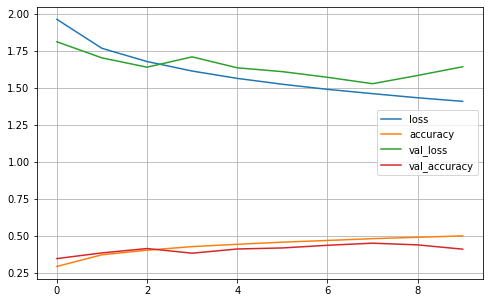

In [0]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim()
print("this is the plot of loss and accuracy")
plt.show()

In [0]:
score_test = model.evaluate(X_test, y_test)
print("the model loss is %s" % score_test[0])
print("the model accuracy is %s" % score_test[1])

313/313 [==============================] - 1s 3ms/step - loss: 1.6240 - accuracy: 0.4111
the model loss is 1.624039888381958
the model accuracy is 0.41110000014305115


In [0]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
cm = confusion_matrix(y_test, y_pred)
print("this is a confusion matrix on test set")
print(cm)

this is a confusion matrix on test set
[[748  30  41  18   1  88   2  27  28  17]
 [134 650   6  27   1  62   2  21  15  82]
 [136  30 298  61  19 358  29  48   7  14]
 [ 67  27  41 235   3 525  20  34  12  36]
 [119  22 188  62 116 370  34  75   6   8]
 [ 44  16  53 121   8 686   3  46   9  14]
 [ 31  26 114 134  17 434 197  27  11   9]
 [ 92  26  44  48  14 286   1 461   2  26]
 [416  99   7  14   2  92   0  12 318  40]
 [173 256   8  41   2  59   3  39  17 402]]


In [0]:
m = tf.keras.metrics.Accuracy()
m.update_state(y_pred, y_test)
print("From confusion matrix, the model accuracy is %s" % m.result().numpy())
print("Besides, there are 10 thousand instances in test set and only %s instances predicted correctly" % sum(np.diag(cm)))


From confusion matrix, the model accuracy is 0.4111
Besides, there are 10 thousand instances in test set and only 4111 instances predicted correctly


The first 20 instances of the CIFAR-10 test set.
The red color title means wrongly predict, the black title is correct.


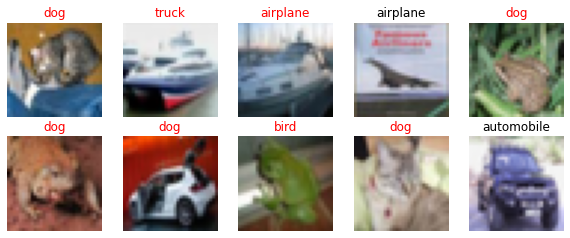

In [0]:
print('The first 10 instances of the CIFAR-10 test set.\nThe red color title means wrongly predict, the black title is correct.')
plt.figure(figsize=(10, 8))
for i in range(10):
  if (y_pred[i] == y_test[i]):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    ax.set_title(class_names[y_pred[i]])
  else:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    ax.set_title(class_names[y_pred[i]], color='red')
plt.show()

### 2.3 Conculsion
* From the plot, the model loss decreases and accuracy increases smoothly as time growth. And the gap between them is getting samller.  
* In the test results, the accuracy is low, which shows MLP is not suitable for dealing with colour pictures. For example, it doesn't catch more information about the pictures so that the model wrongly classified the frog into deer.



## 3. CNN

### 3.1 Find the optimal parameters
Exploring the different hyperparameters such as **kernel size**, **number of kernels**, **dropout rate** and **activation functions**, they are compared by model accuracy and the best one would be picked up and exhibited.

case1
1. kernel_size (3,3)
2. number of kernels 32, 64, 128, 256
3. dropout rate is 0.2
4. activation function of hidden layer is relu and output layer is softmax
5. the model accuracy is 0.7165


case2
1. **kernel_size** (7,7)
2. number of kernels 32, 64, 128, 256
3. dropout rate is 0.2
4. activation function is relu and softmax
5. the score is 0.7287 <br>
Compared with the previous one, the kernel_size is enlarged and the executive time becomes longer (total time is approximately 270s). Besides, the kernel size doesn't affect the model accuracy significantly. However, the accuracy is higher than validation and it is overfitting



case3
1. kernel_size (3,3)
2. **number of kernels** 64, 128, 256, 512
3. dropout rate is 0.2
4. activation function is relu and softmax
5. the score is 0.78 <br>
In order to save the executive time, I chose the (3\*3) kernel size. In here, the number of kernels is increased for each layer. Surprisingly, the model accuracy increases lots. 


case4
1. kernel_size (3,3)
2. number of kernels 64, 128, 256, 512
3. **dropout rate** is 0.5
4. activation function is relu and softmax
5. the score is 0.7692<br>
In this case, I explore the effect of dropout rate. When the dropout rate is equal to 0.5, the model accuracy just changes slightly. It shows the model has got as much as possible information in the deep network, and the pooling layer doesn't affect the output accuracy.


case5
1. kernel_size (3,3)
2. number of kernels 64, 128, 256, 512
3. dropout rate is 0.2
4. activation function is **elu** and softmax
5. the score is 0.7336 <br>
At last, the activation function of the hidden layer is replaced by *elu*. But the executive time decreased. And there are higher accuracies (the highest one is 94%) but whole model accuracy is just about 73.36%. 



**Hence, case3 are picked and the model is displayed below. However, since the random seed for cross-validation is different for each time, the model accuracy will have slightly change.**

### 3.2 Analyze the optimal model

In [0]:
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=(3,3), activation='relu', padding="SAME")
# construct cnn model
model_cnn = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=(3,3), input_shape=[32,32,3]),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(units=512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=10, activation='softmax'),
])
# compile the model
RMS = keras.optimizers.RMSprop(learning_rate=0.0001)
model_cnn.compile(loss="sparse_categorical_crossentropy", optimizer=RMS, 
                      metrics=["accuracy"])

In [0]:
def save_disk() :
  # serialize model to json
  model_json = model_cnn.to_json()
  with open(filepath, "w") as json_file:
    json_file.write(model_json)
  # serialize model to HDF5
  model_cnn.save_weights("%s/Huang_xiaoyan_CNN_final.h5" % pathname)

In [49]:
# ask the user whether retraining should be performed or not
filepath = '%s/Huang_xiaoyan_CNN_final.json' % pathname
answer = input('Retraining the CNN model (y/n)?')
if answer == 'y':
    # construct and train the CNN network using the training set
    print("Retraining the model now...")
    history_cnn = model_cnn.fit(X_training, y_training, 
                                epochs=10, validation_data=(X_valid, y_valid),
                                shuffle=True)    
    # If a model file of the same name already exists to ask the user
    if os.path.exists(filepath) == True:
        anow = input("Overwriting the file or not (y/n)?")
        if anow == 'y':
            save_disk()
            print("Saved model to disk")
        else: 
            print("Refuse overwriting")
    else: 
        save_disk()
        print("Saved model to disk")
else:
    # restore the model of previous version
    # load the final CNN model
    with open(filepath, 'r') as f:
        model_cnn = tf.keras.models.model_from_json(f.read())
    model_cnn.load_weights("%s/Huang_xiaoyan_CNN_final.h5" % pathname)
    model_cnn.compile(loss="sparse_categorical_crossentropy", optimizer=RMS, 
                         metrics=["accuracy"])
    print("Loaded the final model from disk")

Retraining the CNN model (y/n)?y
Retraining the model now...
Epoch 1/10
1407/1407 [==============================] - 47s 33ms/step - loss: 0.0849 - accuracy: 0.9787 - val_loss: 1.2656 - val_accuracy: 0.7978
Epoch 2/10
1407/1407 [==============================] - 46s 33ms/step - loss: 0.0753 - accuracy: 0.9795 - val_loss: 1.8322 - val_accuracy: 0.7962
Epoch 3/10
1407/1407 [==============================] - 46s 33ms/step - loss: 0.0890 - accuracy: 0.9790 - val_loss: 1.4305 - val_accuracy: 0.8056
Epoch 4/10
1407/1407 [==============================] - 46s 33ms/step - loss: 0.0870 - accuracy: 0.9787 - val_loss: 1.5080 - val_accuracy: 0.7858
Epoch 5/10
1407/1407 [==============================] - 46s 33ms/step - loss: 0.0936 - accuracy: 0.9761 - val_loss: 1.6021 - val_accuracy: 0.7474
Epoch 6/10
1407/1407 [==============================] - 46s 33ms/step - loss: 0.0871 - accuracy: 0.9777 - val_loss: 1.3952 - val_accuracy: 0.7898
Epoch 7/10
1407/1407 [==============================] - 47s 33m

In [50]:
score_cnn = model_cnn.evaluate(X_test, y_test)
print("the score is %s " % score_cnn[1])

313/313 [==============================] - 3s 10ms/step - loss: 1.4817 - accuracy: 0.7800
the score is 0.7799999713897705 


In [51]:
from sklearn.metrics import confusion_matrix
y_pred_cnn = model_cnn.predict_classes(X_test)
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
print("this is a confusion matrix on test set")
print(cm_cnn)

this is a confusion matrix on test set
[[847  24  26  10  17   5   7   5  44  15]
 [  3 934   0   5   1   4   1   0  12  40]
 [ 58  13 685  66  66  38  44  18   9   3]
 [ 19  19  32 670  59 115  38  30   9   9]
 [ 15   5  60  54 737  28  35  55   8   3]
 [  9  12  31 174  36 670  16  41   7   4]
 [  7  19  32  86  28  20 788   5  11   4]
 [ 16   7  26  49  38  32   3 819   3   7]
 [ 36  31   7  12   6   5   2   3 884  14]
 [ 37 131   8  16   0   6   7  12  17 766]]


In [52]:
m_cnn = tf.keras.metrics.Accuracy()
m_cnn.update_state(y_pred_cnn, y_test)
print("This accuracy of model is %s" % m_cnn.result().numpy())
print("Besides, there are 10 thousand instances in test set and %s instances predicted correctly" % sum(np.diag(cm_cnn)))

This accuracy of model is 0.78
Besides, there are 10 thousand instances in test set and 7800 instances predicted correctly


The first 10 correct instances of the CIFAR-10 test set.
The red color title means wrongly predict, the black title is correct.


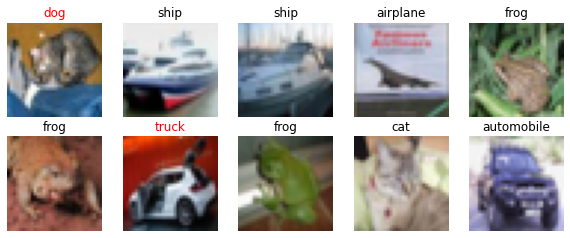

In [53]:
print('The first 10 correct instances of the CIFAR-10 test set.\nThe red color title means wrongly predict, the black title is correct.')
plt.figure(figsize=(10, 8))
for i in range(10):
  if (y_pred_cnn[i] == y_test[i]):
    ax = plt.subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    ax.set_title(class_names[y_pred_cnn[i]])
  else:
    ax = plt.subplot(4,5,i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    ax.set_title(class_names[y_pred_cnn[i]], color='red')
plt.show()

### 3.3 Conclusion and Comparison
* From the confusion matrix, the CNN model has a higher accuracy than MLP.
* These two models both use *relu* as activation function in hidden layers  and *softmax* as output activation function in output layers. In terms of MLP, there are only three kinds of layers, which couldn't catch more information about the colour pictures. For the CNN model, it goes more deeper and obtains more details. Thus, it has more advantage in vision problems.
* Compared with consumption, CNN cost more time and memory.

